In [9]:
%config Completer.use_jedi = False
%load_ext autoreload

import re, time, os, shutil, json, math
import numpy as np
import configdot
from tqdm import tqdm
import monai
from monai.data import DataLoader, Dataset, list_data_collate, decollate_batch

from collections import defaultdict
from IPython.core.debugger import set_trace

import torch
import torch.nn.functional as F
from torch.cuda.amp import autocast
import torch.optim as optim
from models.v2v import V2VModel

from losses import *
from dataset import setup_dataloaders, create_datafile, setup_datafiles, setup_transformations
from utils import save, get_capacity, calc_gradient_norm, get_label, get_latest_weights
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 20

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Checkpoints available

In [10]:
# LOGDIRS_ALL = '/workspace/RawData/FCDNet/logs/features_comparison'

# iter_dir = ['t1',
#  't1_all',
#  't1_blurring-flair',
#  't1_blurring-t1',
#  't1_blurring-t2',
#  't1_cr-flair',
#  't1_cr-t2',
#  't1_curv',
#  't1_entropy',
#  't1_sulc',
#  't1_thickness',
#  't1_variance']

# for dire in iter_dir:
#     iter_l = os.path.join(LOGDIRS_ALL, dire)
#     exp_l = os.listdir(iter_l)
#     print('---------------------------------------')
#     print(f'Checking {dire}...')
#     print('---------------------------------------')
#     for exp in exp_l:
#         if 'v2v' in exp:
#             trual_num = exp.split('@')[0][-1]
#             # path of the 
#             full_path_checkp = os.path.join(iter_l, exp, 'checkpoints')
#             checkpoints_names = os.listdir(full_path_checkp)
#             if os.path.exists(full_path_checkp) and len(checkpoints_names) > 0:
#                 checkpoints_names = sorted(checkpoints_names, key=lambda x: int(re.findall('\d+', x)[0]))
#                 checkpoint = checkpoints_names[-1]
#                 print(f'Chekpoint {checkpoint} found! for {dire} in trial: {trual_num}')
#             else:
#                 print(f'No checkpoints for {dire} in trial {trual_num}!')

In [11]:
# choose specific logdir to visualize
LOGDIR = '/workspace/RawData/FCDNet/logs/features_comparison/t1_all/'

In [28]:
# for logname in os.listdir(LOGDIR):
#     logdir = os.path.join(LOGDIR, logname)
#     config = configdot.parse_config(os.path.join(logdir,'config.ini'))    
#     print(config.dataset.features)
#     print('----------------------')

In [12]:
# set to False to recalculate predictions from scratch, using checkpoint weights
val_preds_path_found = False

# try to find best val preds
if val_preds_path_found:
    # finding if there are valid `val_preds_path`
    val_preds_path_list = []
    for logname in os.listdir(LOGDIR):
        logdir = os.path.join(LOGDIR, logname)
        val_preds_path = os.path.join(logdir, 'best_val_preds')
        if os.path.exists(val_preds_path):
            val_preds_path_list.append(val_preds_path)
    val_preds_path_found = len(val_preds_path_list) > 0
    print(val_preds_path_list)
    
    # if yes - load the `best_val_preds`
    if val_preds_path_found:
        val_preds_path = val_preds_path_list[0]
        best_val_preds = {}
        for label in os.listdir(val_preds_path):
            val_preds_label_path = os.path.join(val_preds_path, label)
            best_val_preds[label] = torch.load(val_preds_label_path)[0,0]

### Load model, setup dataloaders

In [29]:
# choose specific logdir to visualize
logdir = '/workspace/RawData/FCDNet/logs/features_comparison/t1_all/v2v-IN_autocast_DICE_lr-1e-3_nG-bs2-AUG-MASK-to-all-imgch-t1-all_scaler-trial2@26.07.2022-20/'
config = configdot.parse_config(os.path.join(logdir,'config.ini'))

In [30]:
config.dataset.features

['image',
 't2',
 'flair',
 'blurring-t1',
 'blurring-t1',
 'blurring-t2',
 'blurring-Flair',
 'cr-t2',
 'cr-Flair',
 'thickness',
 'curv',
 'sulc',
 'variance',
 'entropy']

In [35]:
# essential for the proper samplers functioning
assert config.opt.val_batch_size == 1
DEVICE = 'cpu' # 'cuda:1'
device = torch.device(DEVICE)

#########
# MODEL #
#########
assert config.model.name == "v2v"
model = V2VModel(config).to(device)
model.load_state_dict(torch.load(get_latest_weights(logdir), map_location=device)['model_state'])

###################
# CREATE DATASETS #
###################
train_loader, val_loader = setup_dataloaders(config)

print('val dataloder len: ', len(val_loader), 'train dataloder len: ', len(train_loader))

Train set length: 80
Test set length: 10
val dataloder len:  10 train dataloder len:  40


# Forward pass

In [37]:
PREDICT_LABELS = True

if PREDICT_LABELS:
    predictions_path = os.path.join(logdir, 'predictions')
    if not os.path.exists(predictions_path):
        os.makedirs(predictions_path)
        
    model_dict = torch.load(get_latest_weights(logdir))
    model.load_state_dict(model_dict['model_state'])
    model.eval()

In [ ]:
# test_data_indcs = ['6', '7', '40', '45', '75', '84', '14', '42', '68NS', '71NS']
# feat_params = config.dataset.features
# test_files = create_datafile(test_data_indcs, feat_params, mask=True)

# _, val_trans =  setup_transformations(config)
# test_ds = monai.data.Dataset(data=test_files[0], transform=val_trans)
# test_loader = DataLoader(test_ds, 
#                         batch_size=1, 
#                         num_workers=0, 
#                         collate_fn=list_data_collate,
#                         shuffle=False # important not to shuffle, to ensure label correspondence
#                         )

In [ ]:
# check_data = monai.utils.misc.first(test_loader)
# check_data['seg'].shape, check_data['image'].shape

0it [00:00, ?it/s]

Label: n51
n51 0.015432944521307945


/root/miniconda3/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/root/miniconda3/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/root/miniconda3/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


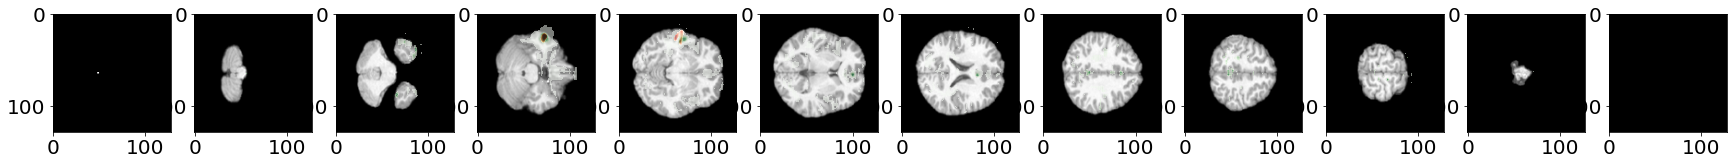

1it [00:36, 36.14s/it]

Label: n29
n29 0.03465833514928818


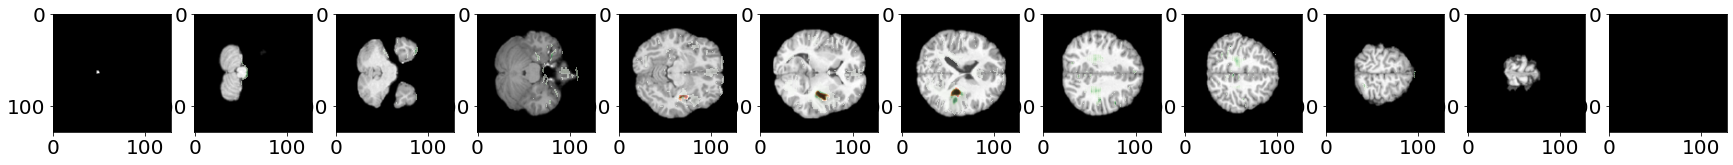

2it [01:11, 35.91s/it]

Label: n41
n41 0.024934714660048485


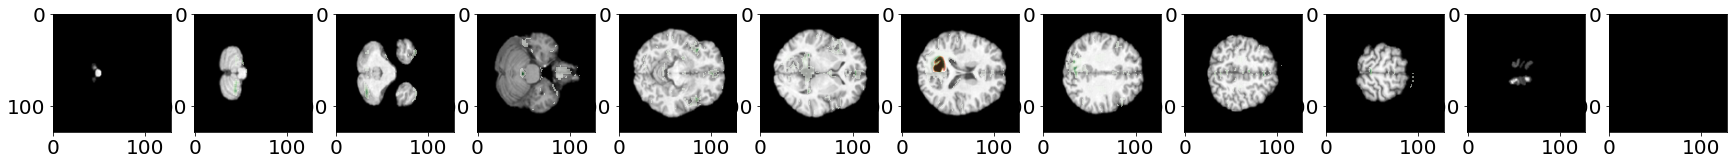

3it [01:33, 31.27s/it]

Label: G256
G256 0.00041789415990933776


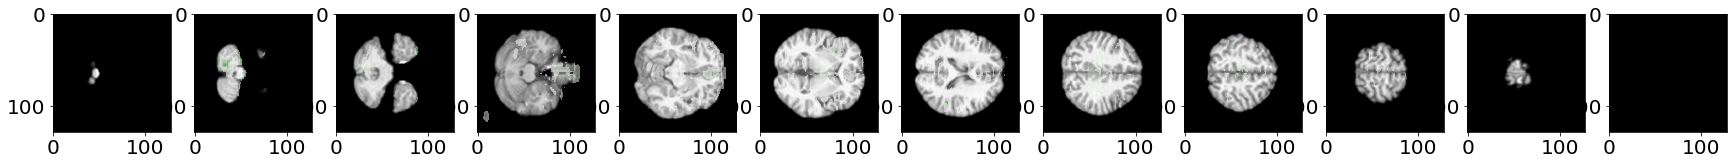

4it [03:06, 46.71s/it]

Label: n58
n58 0.0001639384136069566


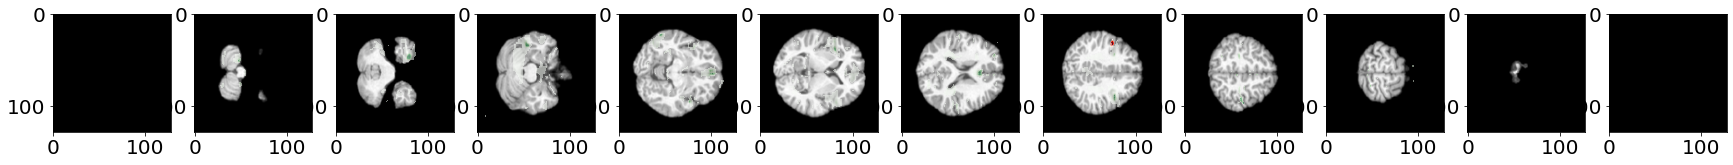

5it [03:26, 41.20s/it]

Label: G258
G258 0.0030255038291215897


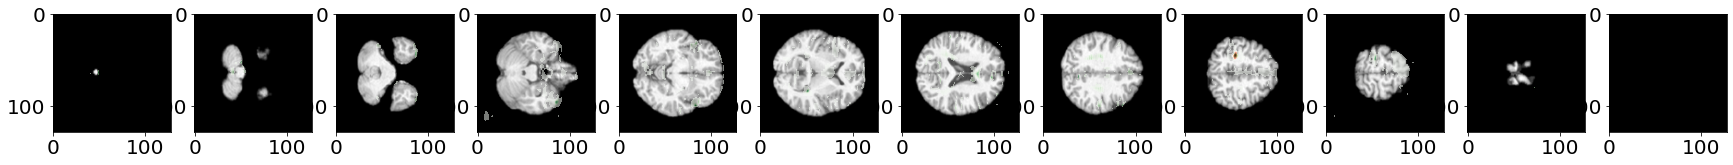

6it [03:43, 37.31s/it]

Label: n50
n50 0.013225750997662544


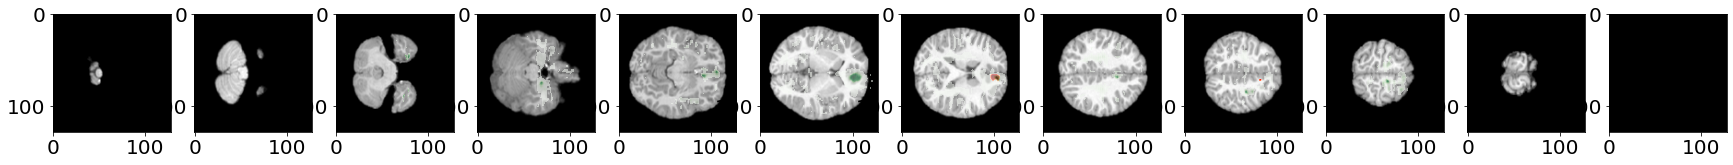

7it [04:00, 34.35s/it]

Label: n23
n23 0.008479185402393341


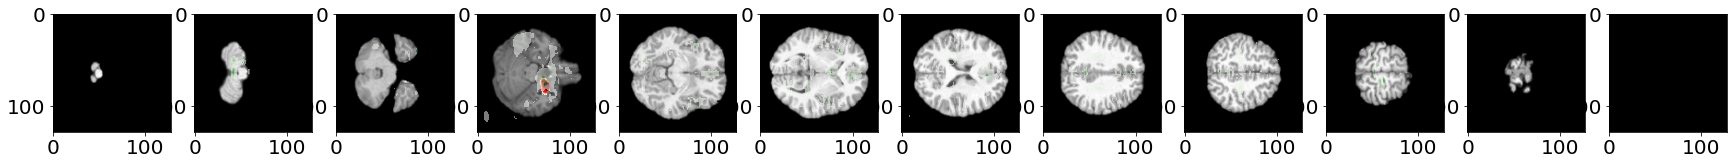

8it [04:16, 32.09s/it]

Label: n83
n83 0.005089611746370792


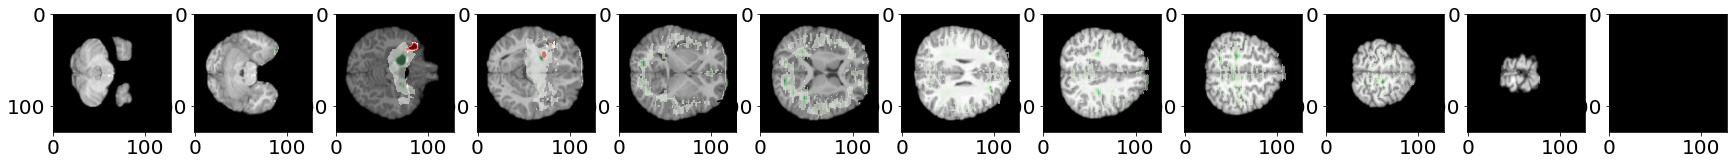

9it [04:33, 30.43s/it]

Label: G414
G414 0.022944411262869835


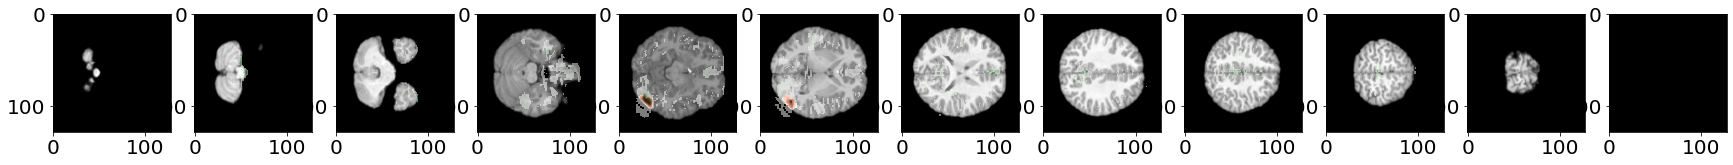

10it [04:50, 29.01s/it]


In [38]:
dataloader = val_loader

brains = {}
labels_gt = {}
metric_dict = defaultdict(list)
labels_pred = {}
labels_ref = {}

with torch.no_grad():

    # bs = 1
    # brain_tensor - [1,C,H,W,D]
    # mask_tensor - [1,1,H,W,D]
    # label_tensor - [1,1,H,W,D]
    
    #######################
    # ITERATE OVER BRAINS #
    #######################
    iterator = enumerate(dataloader)
   
    
    for iter_i, data_tensors in tqdm(iterator):
        brain_tensor, label_tensor = data_tensors['image'], data_tensors['seg']

        brain_tensor = brain_tensor.to(device)
        label_tensor = label_tensor.to(device)

        label = get_label(dataloader.dataset.data[iter_i]['seg'])
        if PREDICT_LABELS:
            label_tensor_predicted = model(brain_tensor)
        else:
            label_tensor_predicted = torch.tensor(best_val_preds[label][None,None,...]).to(device)
        print(f'Label: {label}')

        cov = coverage(label_tensor_predicted, label_tensor).item()
        fp = false_positive(label_tensor_predicted, label_tensor).item()
        fn = false_negative(label_tensor_predicted, label_tensor).item()
        dice = dice_score(label_tensor_predicted.detach() > 1e-4, label_tensor.detach()).item()

        metric_dict['coverage'].append(cov) # a.k.a recall
        metric_dict['false_positive'].append(fp)
        metric_dict['false_negative'].append(fn)
        metric_dict['dice_score'].append(dice)
        
        print(label, dice)
        plt.figure("image", (30, 10))
        brains[label] = brain_tensor[0,0].detach().cpu().numpy()
        labels_gt[label] = label_tensor[0,0].detach().cpu().numpy()
        label_tensor_predicted = label_tensor_predicted[0,0].detach().cpu()
        labels_pred[label] = label_tensor_predicted.numpy()
        labels_pred[label] = labels_pred[label]
        
        masked_labels_pred = np.ma.masked_where(labels_pred[label] < 1e-4, labels_pred[label])
        masked_labels_gt = np.ma.masked_where(labels_gt[label] < 1e-4, labels_gt[label])
        
        for i in range(12):
            plt.subplot(1, 12, i+1)
            ind = math.floor(127 * (i / 12))
            plt.imshow(brains[label][:,:,ind], cmap='gray')
            plt.imshow(masked_labels_gt[:,:,ind], cmap='Reds')
            plt.imshow(masked_labels_pred[:,:,ind], cmap='Greens', alpha=0.5)
        
        if PREDICT_LABELS:
            torch.save(label_tensor_predicted, os.path.join(predictions_path, f'{label}'))
        plt.show()

In [40]:
# plt.ion()
# plt.figure(figsize=(10,5),dpi=200)
# plt.bar(metric_dict['dice_score'].keys(), metric_dict['dice_score'].values(), alpha=0.5, label='V2V')
# exp_name = logdir.split('/')[1]
# plt.title(f'Val')
# plt.ylabel('Dice score')
# plt.xticks(rotation=45)
# plt.legend()
# plt.show()

In [41]:
# plt.ion()
# plt.figure(figsize=(10,5),dpi=200)
# plt.bar(metric_dict['coverage'].keys(), metric_dict['coverage'].values(), alpha=0.5, label='V2V')
# exp_name = logdir.split('/')[1]
# plt.title(f'Val')
# plt.ylabel('Recall')
# plt.xticks(rotation=45)
# plt.legend()
# plt.show()

In [42]:
# dices = np.array(list(metric_dict['dice_score'].values()))
# labels = np.array(list(metric_dict['dice_score'].keys()))

In [43]:
# image_path = os.path.join(logdir, 'images_val')
# if not os.path.exists(image_path):
#     os.makedirs(image_path)

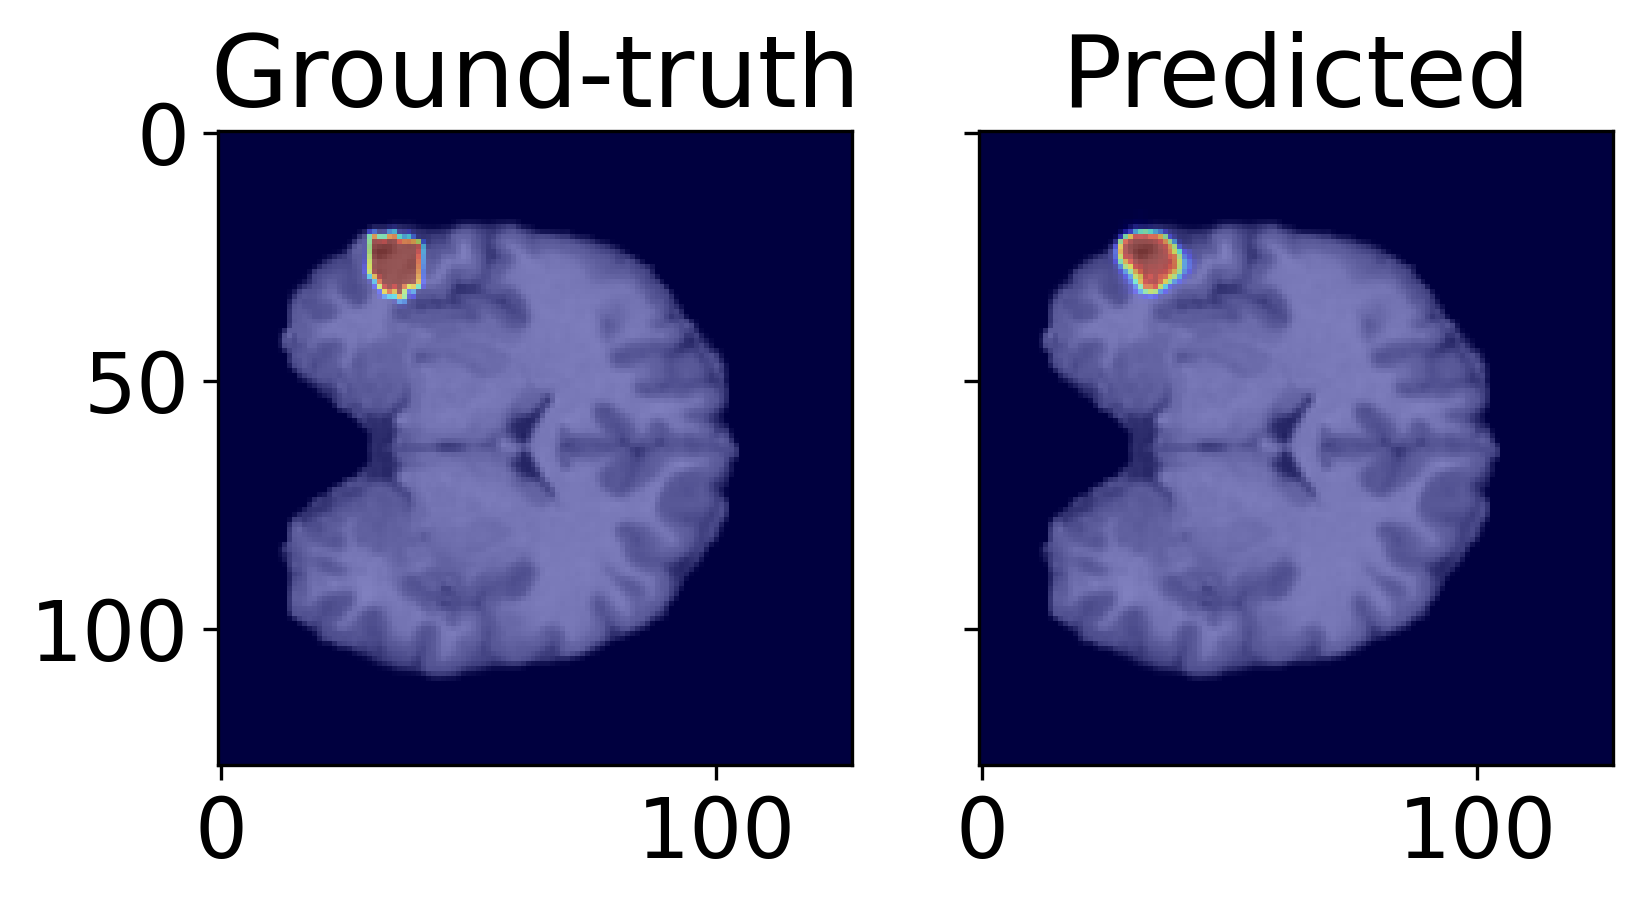

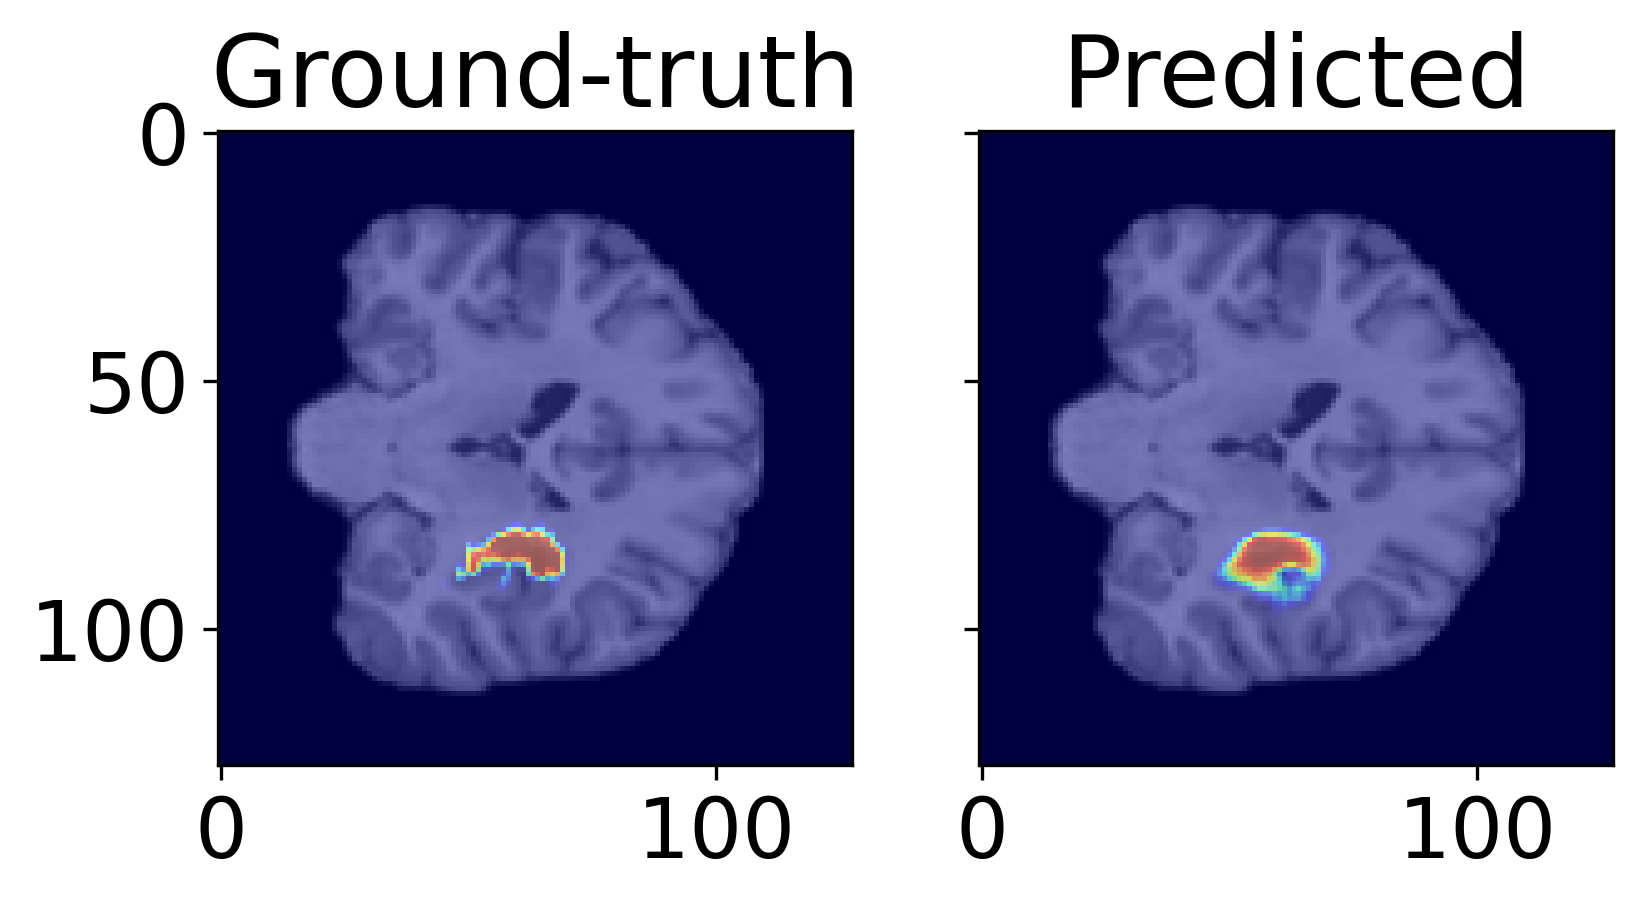

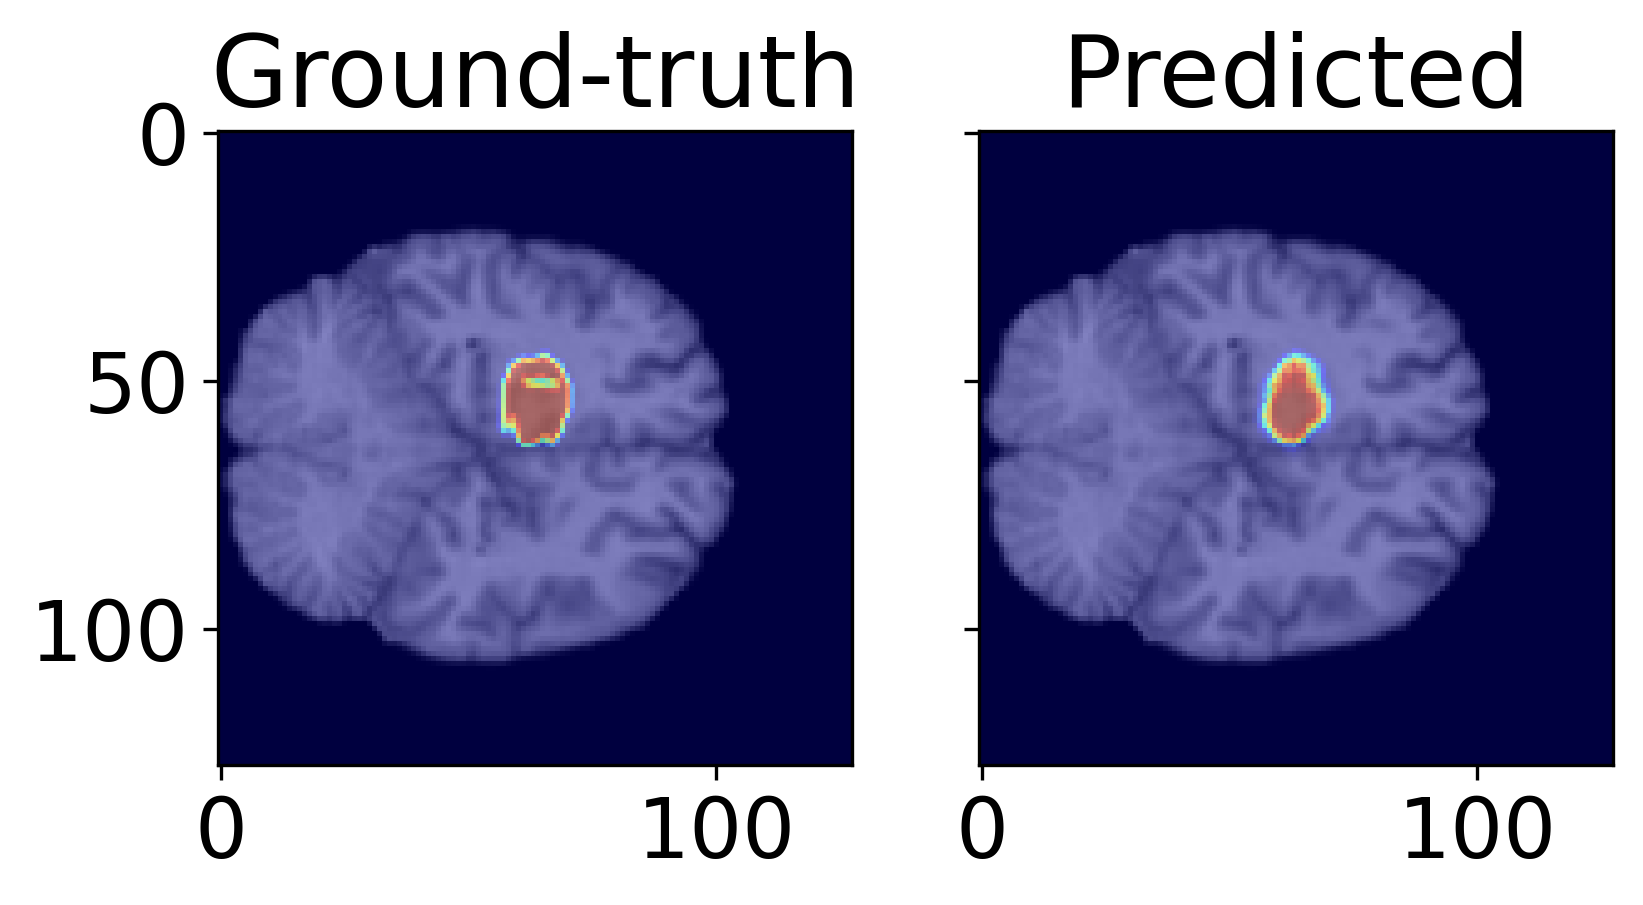

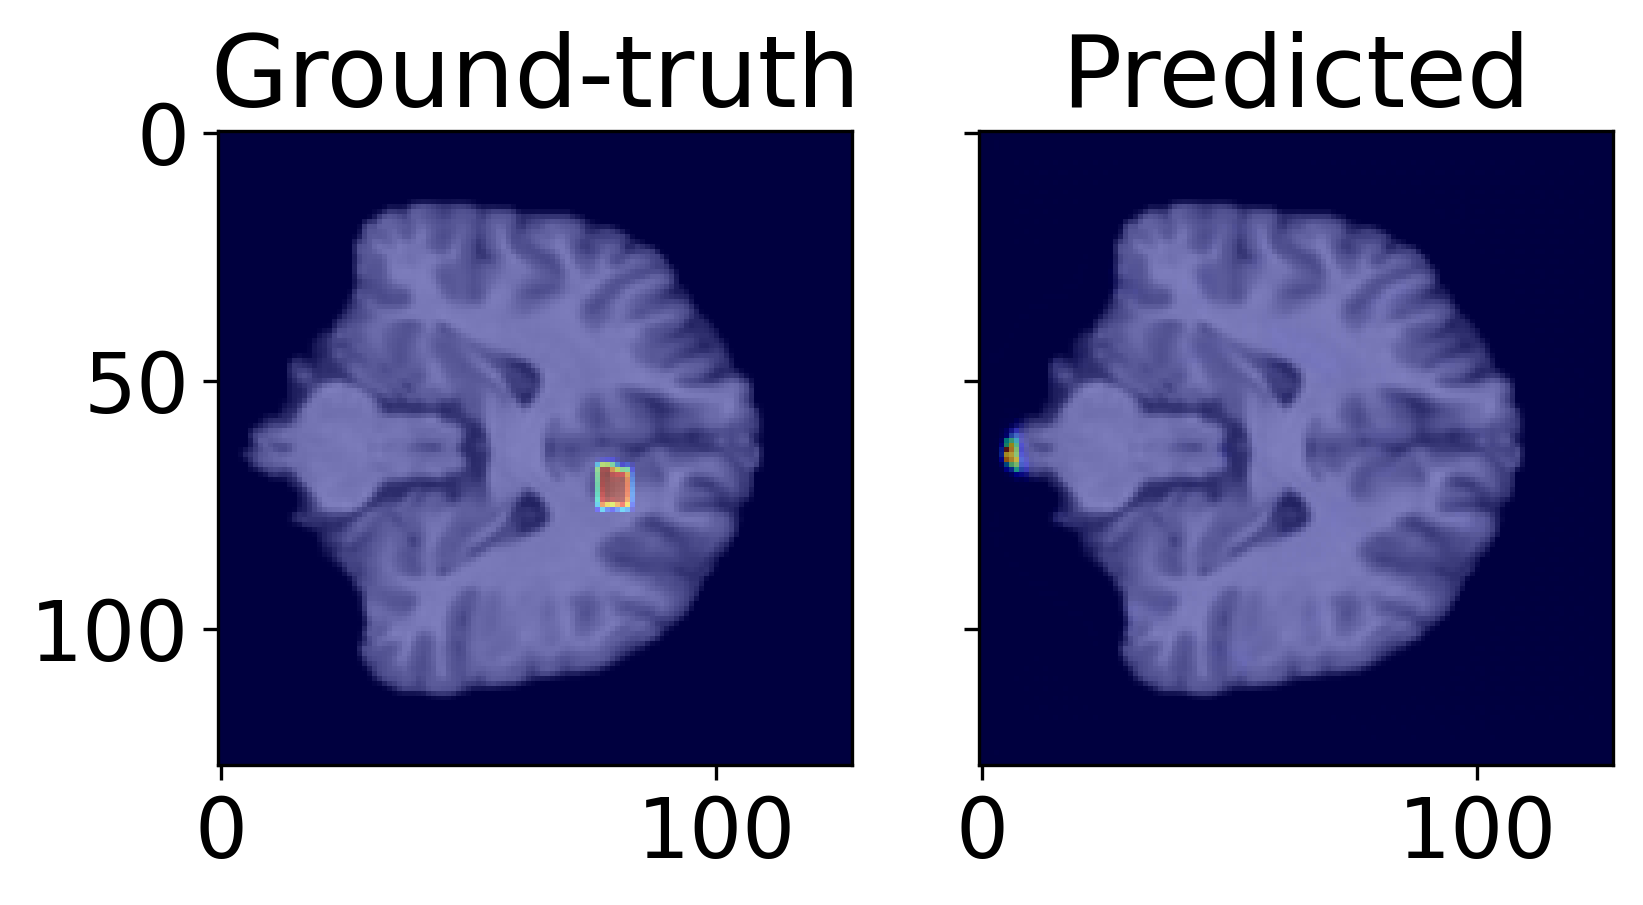

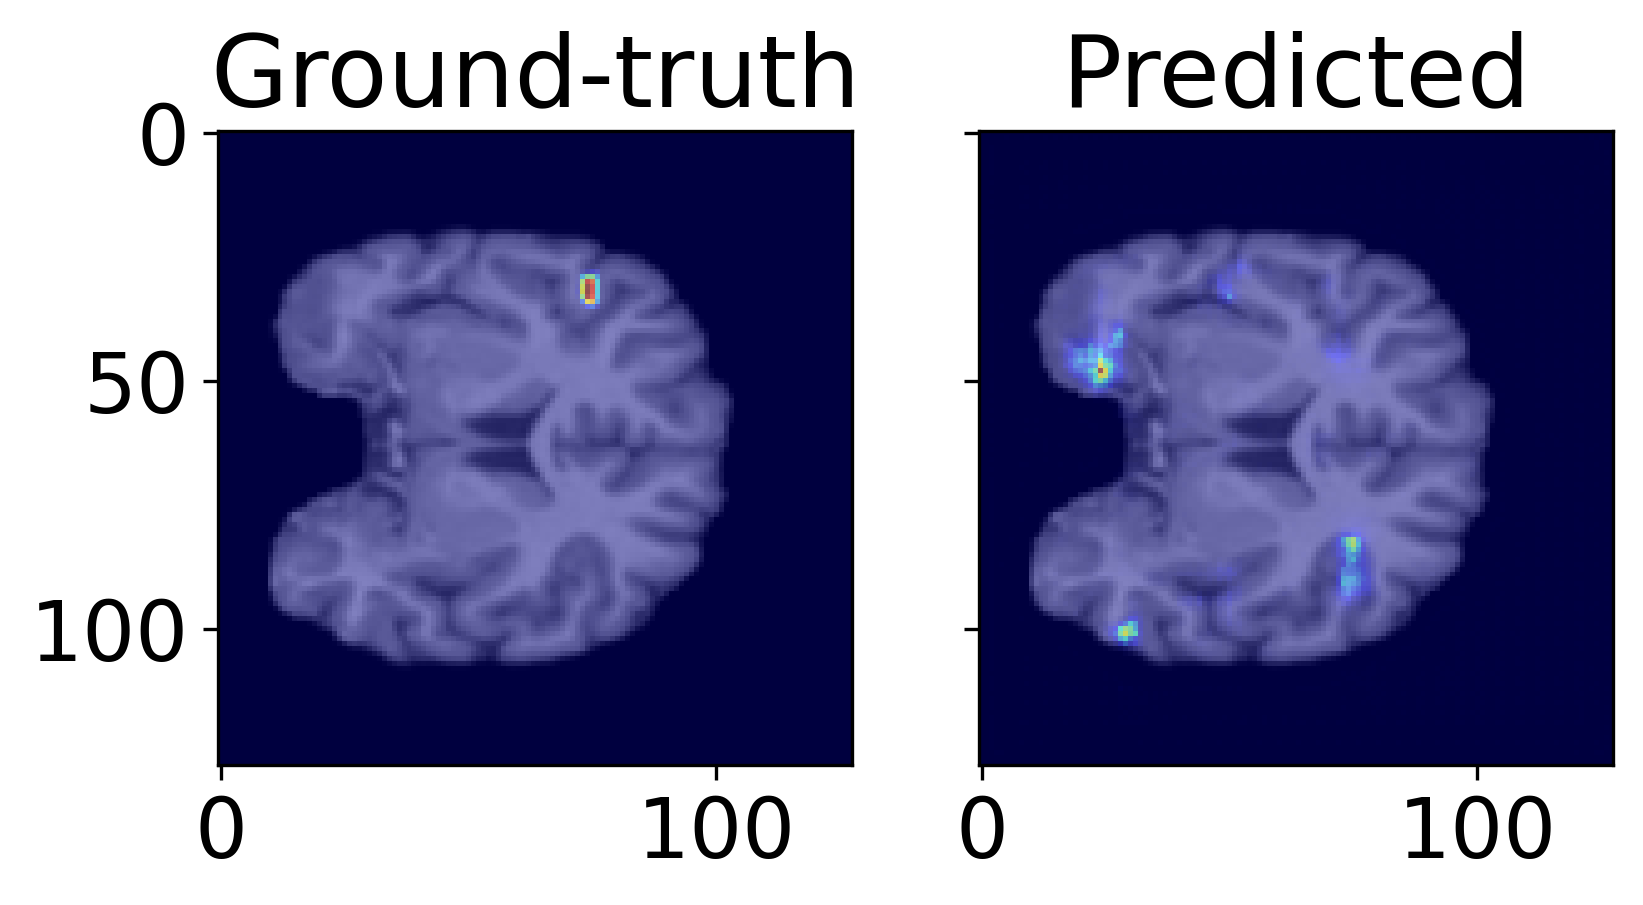

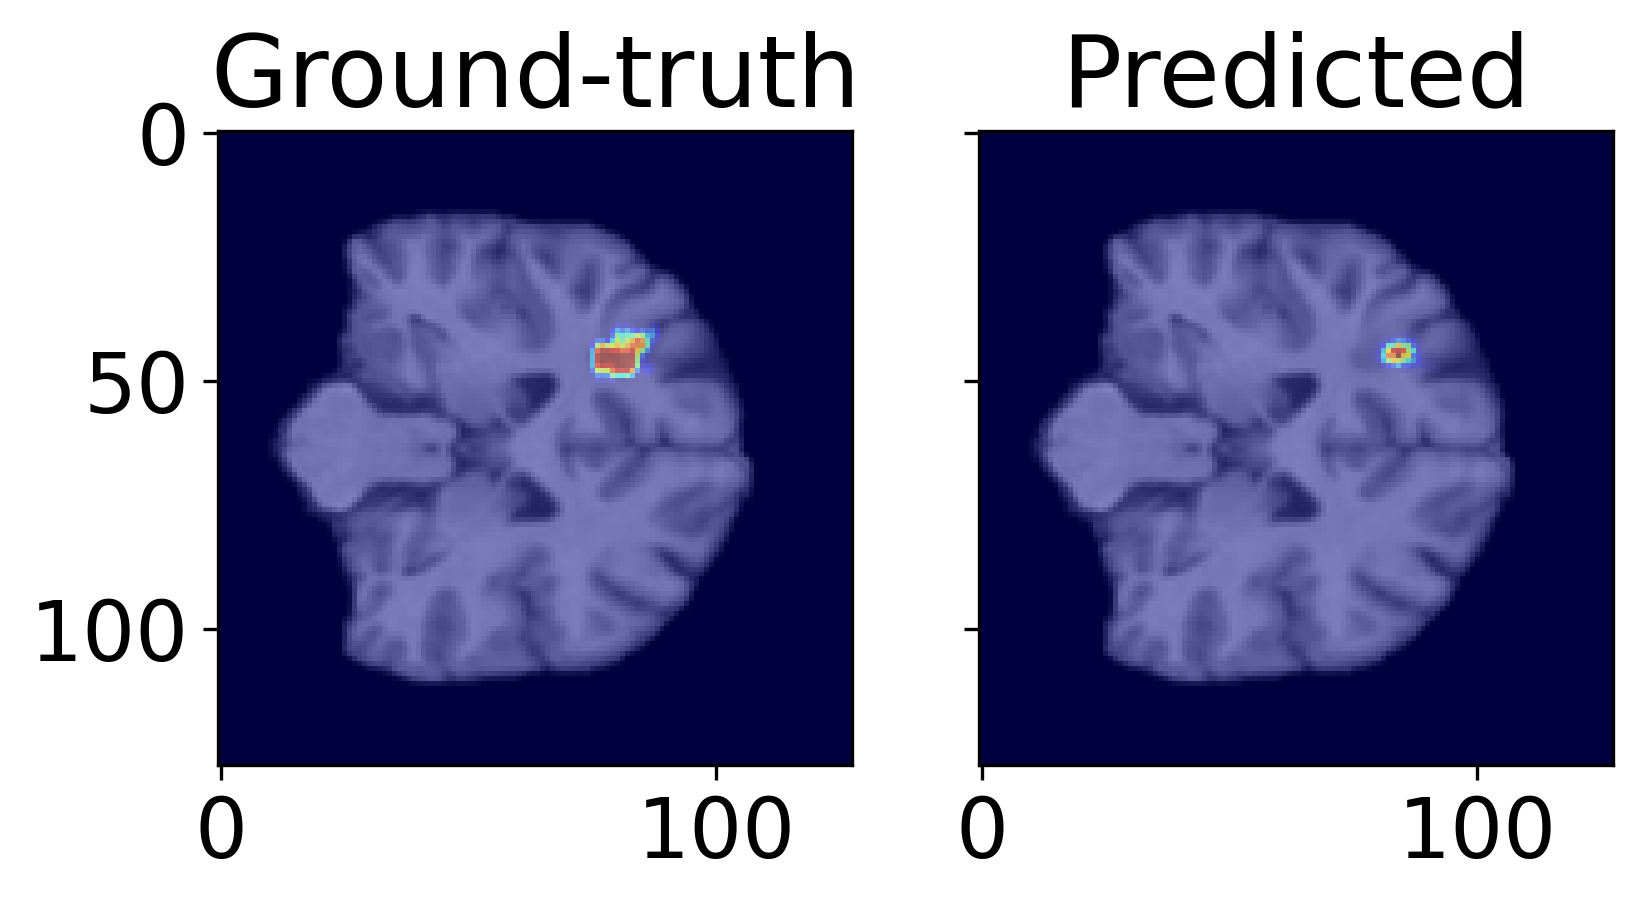

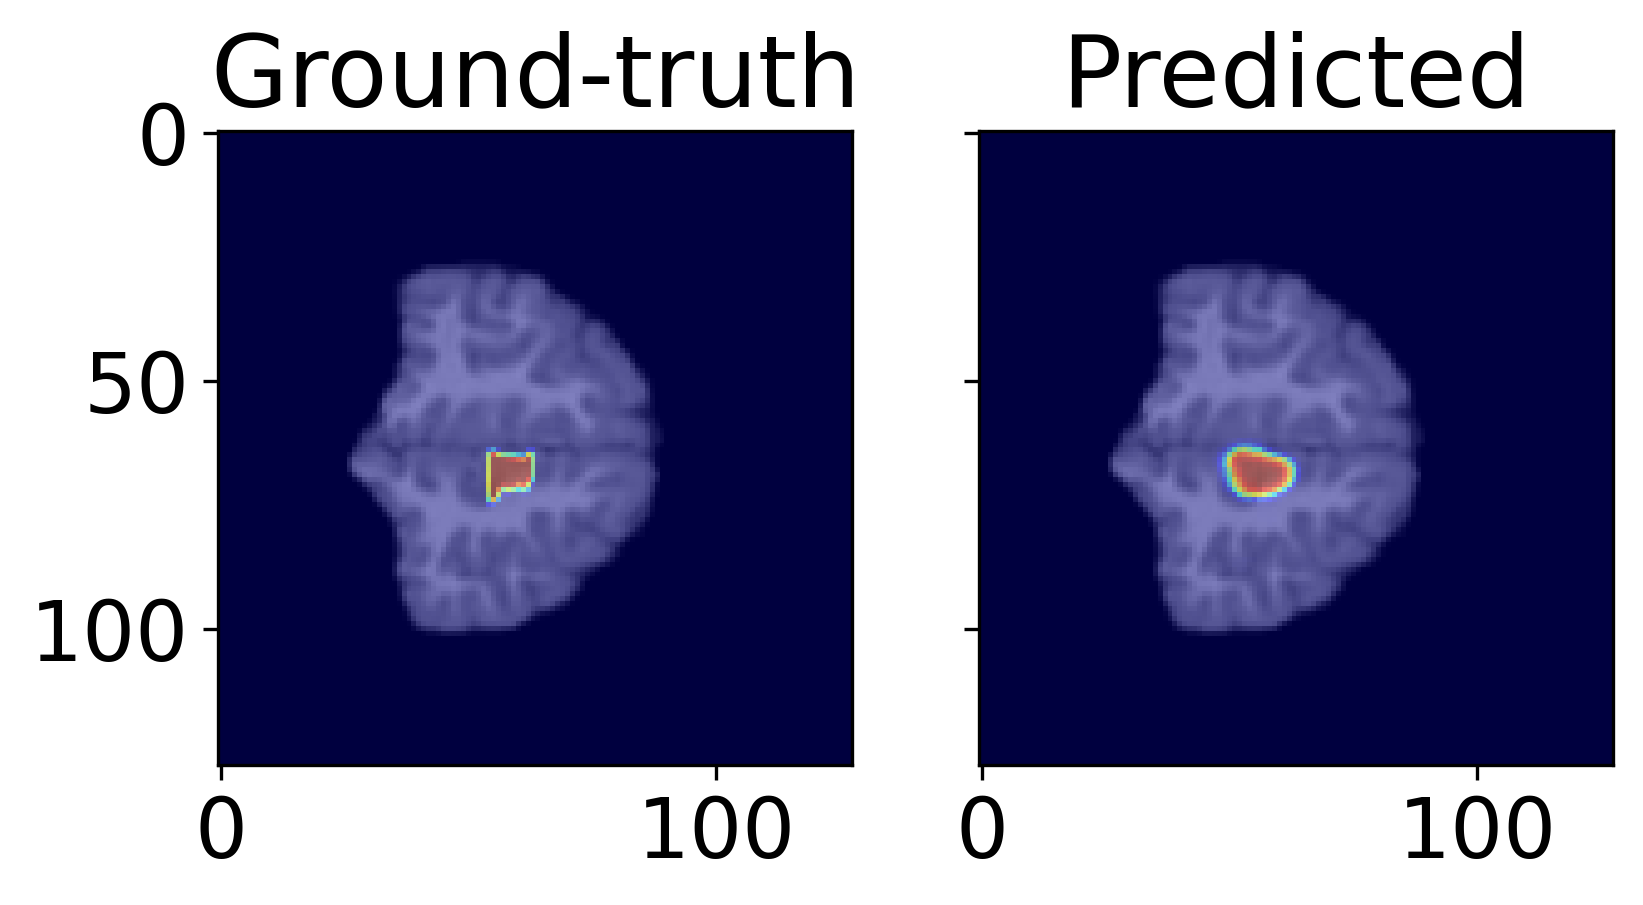

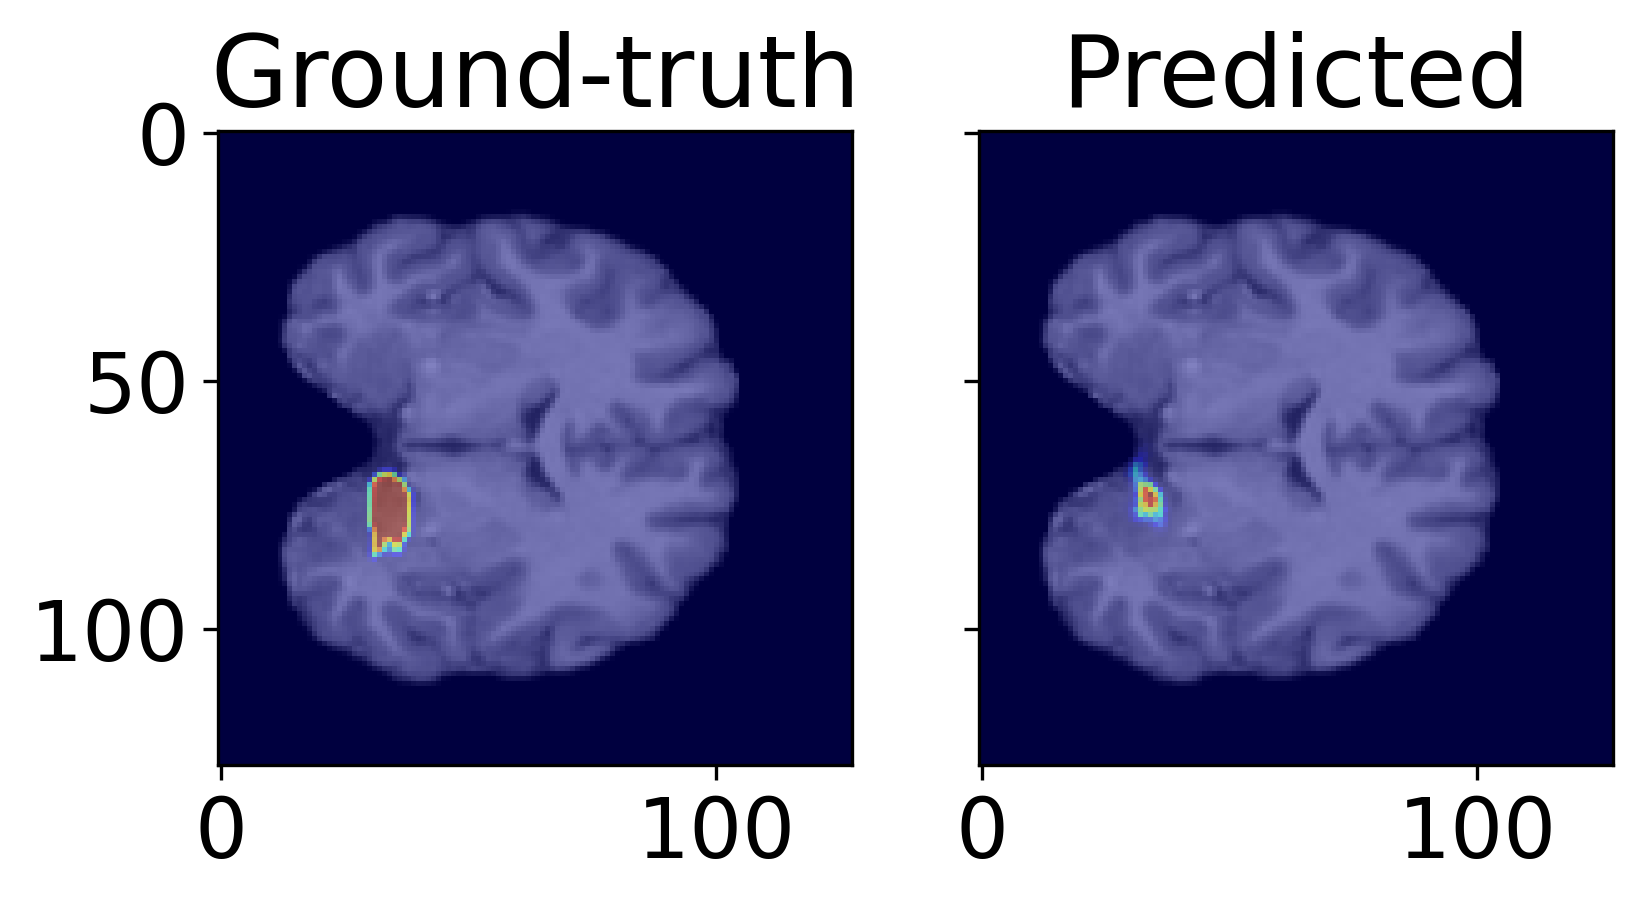

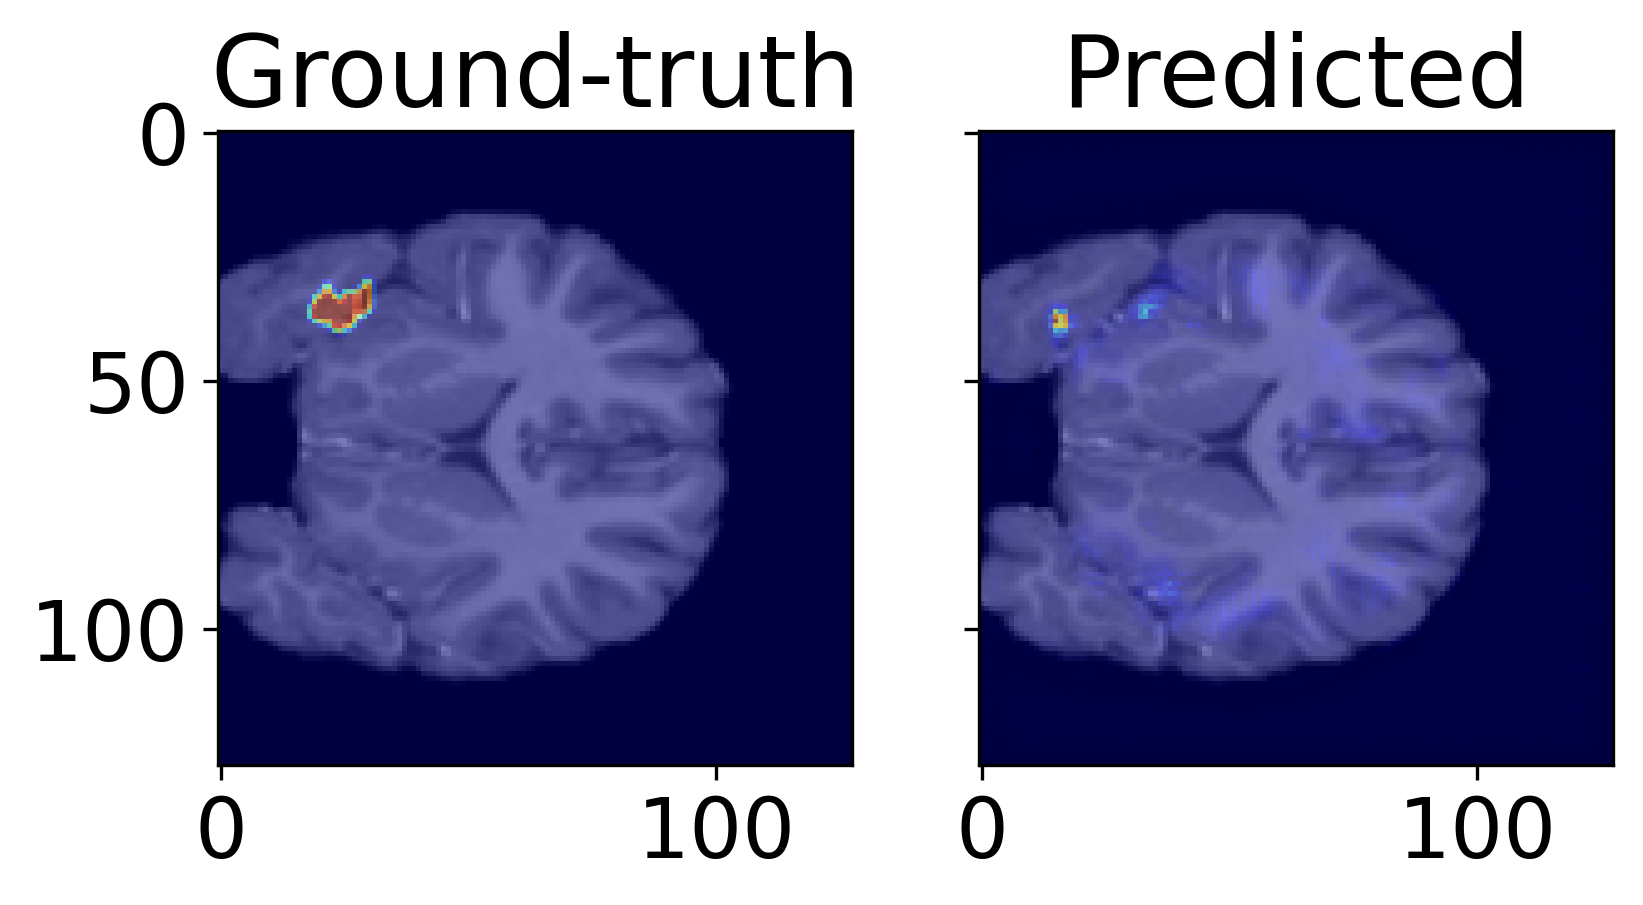

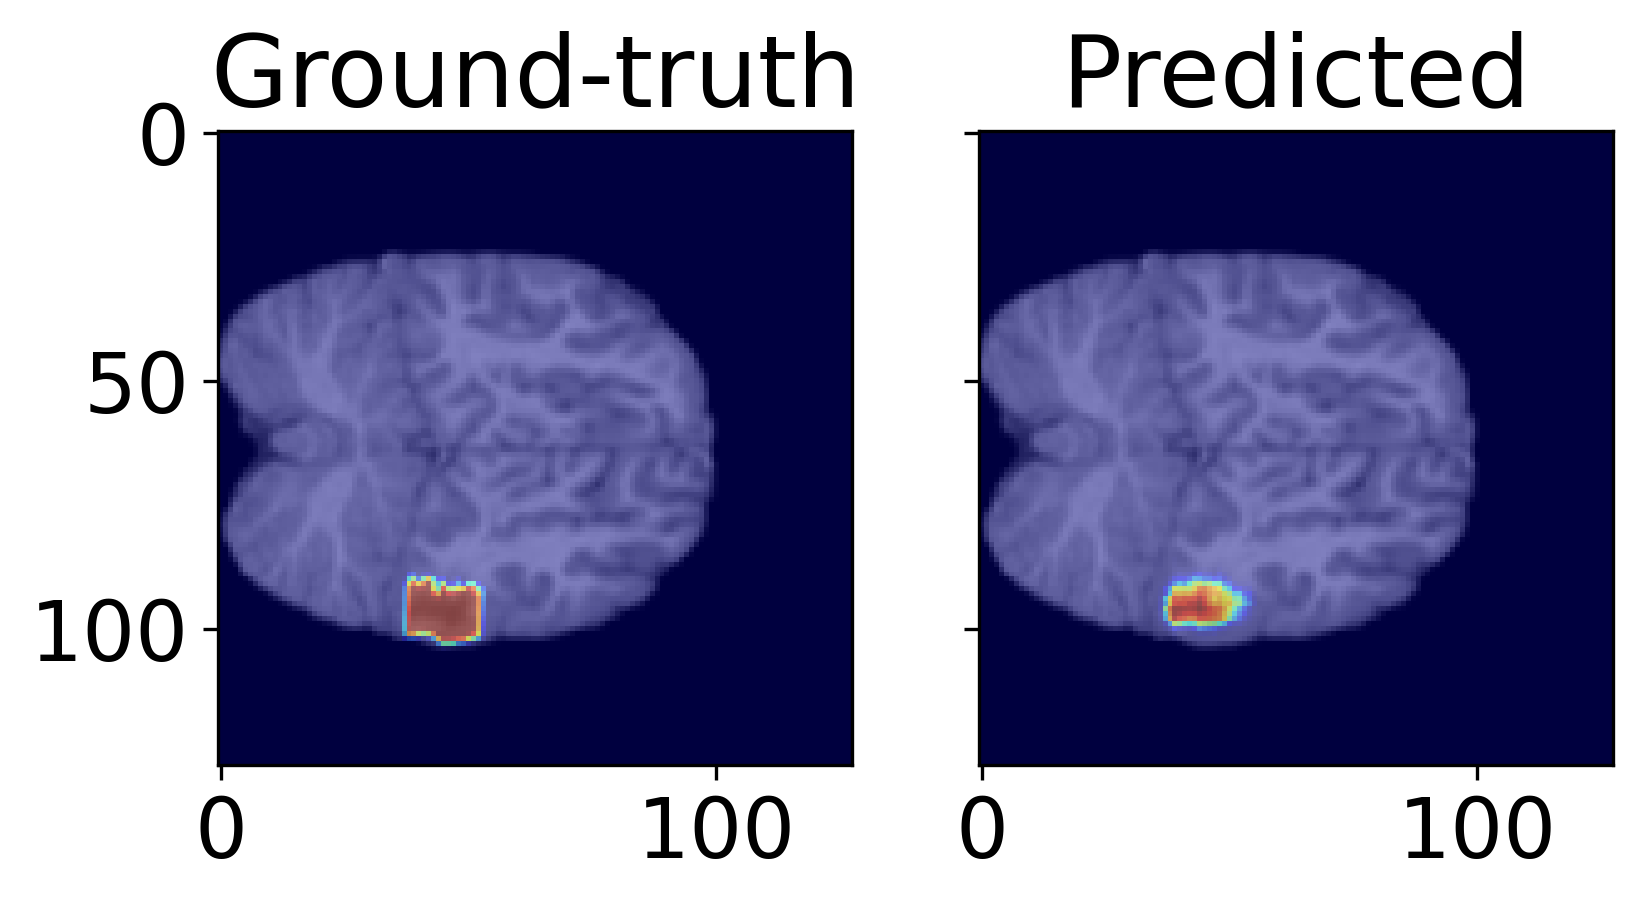

In [48]:
for label in brains.keys():

    brain = brains[label]
    label_gt = labels_gt[label]
    label_pred = labels_pred[label]

    fig, ax = plt.subplots(1,2, sharex=True, sharey=True, dpi=300)
    X_max, Y_max, Z_max = brain.shape

    y_slice_pos = label_gt.sum(axis=(0,-1)).argmax()

    brain_slice = brain[:,y_slice_pos,:]
    label_gt_slice = label_gt[:,y_slice_pos,:]
    ax[0].imshow(brain_slice, cmap='gray')
    ax[0].imshow(label_gt_slice, cmap='jet', alpha=0.5, interpolation='none')
    ax[0].set_title('Ground-truth')

    label_pred_slice = label_pred[:,y_slice_pos,:].astype(float)
    ax[1].imshow(brain_slice, cmap='gray')
    ax[1].imshow(label_pred_slice, cmap='jet', alpha=0.5, interpolation='none')
    ax[1].set_title('Predicted')
    
    # fig.suptitle(f'Label: {label}', y=.85)

    plt.show()
    